In [1]:
from nmon import *

In [2]:
N = 2
M = 2
EC_shunt = 0.18 * 1

# choose sparse: 100/100, 100/10, 100/5, 100/3
# choose dense: 100/2

nmon = Nmon(N=N, M=M, EJN=30*EC_shunt, EJM=30*EC_shunt, EC_shunt=EC_shunt)

nmon.hamiltonian_calc(flux=0.0, ng=[0.0, 0, 0], num_levels=3, make_plot=False, just_H=True, cutoff=4)#compute_cutoff(nmon.EJN, nmon.EJM, nmon.EC_total, cutoff_space=[2, 8]))

# nmon.H_arr = nmon.nmon_circ.hamiltonian().toarray() # sparse array

# nmon.H_arr = (np.real(nmon.H_arr))
# nmon.bound_state_energies, nmon.H_arr

# print(nmon.H_arr)

EJM_idx, EJN_idx = np.where(nmon.H_arr[0] != 0)[0][1:][0], np.where(nmon.H_arr[0] != 0)[0][1:][-1]
# np.absolute(max(np.diag(nmon.H_arr)) / nmon.H_arr.shape[0]**2 / (M*nmon.H_arr[0, EJM_idx] + N * nmon.H_arr[0, EJN_idx]) )
np.absolute(max(np.diag(nmon.H_arr)) / (nmon.H_arr.shape[0]**(1/3) - 1 )/2  / (M*nmon.H_arr[0, EJM_idx] + N * nmon.H_arr[0, EJN_idx]) ) / 1e3

np.float64(0.038580246913580266)

In [3]:
Matr = nmon.nmon_circ.transformation_matrix
Matr_inv = np.linalg.inv(Matr)
Matr, Matr_inv, nmon.sym_hamiltonian

(array([[1, 1, 0],
        [1, 0, 1],
        [1, 0, 0]]),
 array([[ 0.,  0.,  1.],
        [ 1., -0., -1.],
        [-0.,  1., -1.]]),
 (-5.4*cos(θ1) - 5.4*cos((2πΦ_{1}) - θ2) - 5.4*cos(θ1 + θ3) - 5.4*cos(θ2 - θ3)) + (41.845125*n1**2 - 82.976417*n1*n2 - 83.333333*n1*n3 + 83.69025*n1*n_g1 - 82.976417*n1*n_g2 - 83.333333*n1*n_g3 + 41.845125*n2**2 + 83.333333*n2*n3 - 82.976417*n2*n_g1 + 83.69025*n2*n_g2 + 83.333333*n2*n_g3 + 83.333333*n3**2 - 83.333333*n3*n_g1 + 83.333333*n3*n_g2 + 166.666667*n3*n_g3 + 41.845125*n_g1**2 - 82.976417*n_g1*n_g2 - 83.333333*n_g1*n_g3 + 41.845125*n_g2**2 + 83.333333*n_g2*n_g3 + 83.333333*n_g3**2))

In [4]:
nmon.H = scipy.sparse.csr_matrix(np.absolute(nmon.H))
eval, evec = spla.eigsh(nmon.H, which='SA', k=3)
eval

array([-2.08043939, -0.86106275, -0.16791372])

In [5]:
import numpy as np
from numba import njit

@njit
def compute_eigh(H):
    return np.linalg.eigh(H)

In [6]:
nmon.H_arr = np.absolute(nmon.H_arr)
eigenvalues, eigenvectors = compute_eigh(nmon.H_arr)
eigenvalues[:3]

array([-2.08043939, -0.86106275, -0.16791372])

In [7]:
# 5: [-41.45945013+0.j -37.01611931+0.j -32.47863842+0.j -27.65682913+0.j
#  -22.40622389+0.j -16.7336302 +0.j]
# 6: [-41.46364987+0.j -37.06239792+0.j -32.70877442+0.j -28.3569809 +0.j
#  -23.91948289+0.j -19.30238948+0.j]
# 7: [-41.46387224+0.j -37.06582614+0.j -32.7333756 +0.j -28.46558966+0.j
#  -24.25166068+0.j -20.06309563+0.j]

In [8]:
from nmon import *

EC_shunt = 0.18

N = 2
M = 2

N_EJN = 20
N_EJM = 20
N_flux = 5

flux_list = np.linspace(0, 0.5, N_flux)
EJM_list = np.linspace(1 * EC_shunt, 60 * EC_shunt, N_EJN)
EJN_list = np.linspace(1 * EC_shunt, 60 * EC_shunt, N_EJM)

# Generate all combinations of ng values
ng_probes = [0, 0.25, 0.5, 0.75]
# ng_combinations = np.array(list(combinations_with_replacement(ng_probes, N + M - 1)))
ng_combinations = [[0,0,0],
                   [0, 0.25, 0.5],
                   [0.0, 0.5,0.25],
                   [0.5, 0.25,0.0],
                   [0.5, 0.25, 0.5],
                   [0.25, 0.5, 0.25],
                   [0.25, 0.25, 0.25],
                   [0.5, 0.5, 0.5]
                   ]

relative_anharm_list = np.full((N_EJM, N_EJN, N_flux), None)
w01_list = np.full((N_EJM, N_EJN, N_flux), None)
w12_list = np.full((N_EJM, N_EJN, N_flux), None)
w01_variation_list = np.full_like(w01_list, None)
w01_variation_list_precise = np.full_like(w01_list, None)

# To store the ng values corresponding to min and max w01
w01_ng_min = np.empty((N_EJM, N_EJN, N_flux), dtype=object)
w01_ng_max = np.empty((N_EJM, N_EJN, N_flux), dtype=object)

for i in range(N_EJM):
    for j in tqdm(range(N_EJN)):
        nmon = Nmon(N=N, M=M, EJM=EJM_list[i], EJN=EJN_list[j], EC_shunt=EC_shunt)
        for k, flux in enumerate(flux_list):

            w01_local = []
            local_ng_values = []
            local_relative_anharm = []
            local_w12 = []

            # Iterate over all ng combinations
            for ng in ng_combinations:
                try:
                    nmon.hamiltonian_calc(flux=flux, ng=ng, num_levels=6, make_plot=False, just_H=False,
                                        cutoff=compute_cutoff(nmon.EJN, nmon.EJM, nmon.EC_total, cutoff_space=[2, 8]))
                except Exception:
                    continue

                # Store w01 for the current ng
                w01_local.append(nmon.transition_freqs[0])
                local_ng_values.append(tuple(ng))

                if len(nmon.transition_freqs) > 1:
                    local_w12.append( nmon.transition_freqs[1])
                    local_relative_anharm.append(nmon.relative_anharm)

            try:
                EJM_idx, EJN_idx = np.where(nmon.H_arr[0] != 0)[0][1:][0], np.where(nmon.H_arr[0] != 0)[0][1:][-1]

                # np.absolute(max(np.diag(nmon.H_arr)) / nmon.H_arr.shape[0]**2 / (M*nmon.H_arr[0, EJM_idx] + N * nmon.H_arr[0, EJN_idx]) )
                up_value = max(np.diag(nmon.H_arr)) / (nmon.H_arr.shape[0]**(1/3) - 1 )/2
                EJM_sum = M*nmon.H_arr[0, EJM_idx]
                EJN_sum = N*nmon.H_arr[0, EJN_idx] 

                # Compute relative anharmonicity
                # Calculate w01 variation and store ng values for min and max w01
                max_idx = np.argmax(w01_local)
                min_idx = np.argmin(w01_local)

                w01_list[i, j, k] = w01_local[max_idx]  # Store the minimal w01 for any ng configuration

                w12_list[i, j, k] = local_w12[max_idx]
                relative_anharm_list[i, j, k] = local_relative_anharm[max_idx]

                w01_variation_list[i, j, k] = (np.absolute( up_value / (EJM_sum)) / 2e4 + np.absolute( up_value / (EJN_sum)) / 2e4) / w01_local[max_idx]
                w01_variation_list_precise[i, j, k] = (w01_local[max_idx] - w01_local[min_idx]) / w01_local[max_idx]
                w01_ng_min[i, j, k] = local_ng_values[min_idx]
                w01_ng_max[i, j, k] = local_ng_values[max_idx]

            except Exception:
                continue

# At the end, w01_ng_min and w01_ng_max store the ng values for which w01 is minimal or maximal.
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJM_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJM_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJN_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJN_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_flux_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), flux_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_rel_anharm_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), relative_anharm_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_variation_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list_precise.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_variation_list_precise)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_ng_max.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_ng_max)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_ng_min.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_ng_min)



100%|██████████| 20/20 [32:00<00:00, 96.04s/it]   


In [9]:
# At the end, w01_ng_min and w01_ng_max store the ng values for which w01 is minimal or maximal.
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJM_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJM_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJN_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJN_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_flux_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), flux_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_rel_anharm_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), relative_anharm_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_variation_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list_precise.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_variation_list_precise)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_ng_max.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_ng_max)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_ng_min.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_ng_min)


In [4]:


EJM_list = np.load("./data_arrays/N={}_M={}_EC_shunt={}_EJM_list.npy".format(N, M, round(EC_shunt, 2)))
EJN_list = np.load("./data_arrays/N={}_M={}_EC_shunt={}_EJN_list.npy".format(N, M, round(EC_shunt, 2)))
flux_list = np.load("./data_arrays/N={}_M={}_EC_shunt={}_flux_list.npy".format(N, M, round(EC_shunt, 2)), allow_pickle=True)
relative_anharm_list_flux = np.load("./data_arrays/N={}_M={}_EC_shunt={}_rel_anharm_list.npy".format(N, M, round(EC_shunt, 2)), allow_pickle=True)
w01_list_flux = np.load("./data_arrays/N={}_M={}_EC_shunt={}_w01_list.npy".format(N, M, round(EC_shunt, 2)), allow_pickle=True)
w01_variation_list_flux = np.load("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list.npy".format(N, M, round(EC_shunt, 2)), allow_pickle=True)
w01_variation_list_precise = np.load("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list_precise.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), allow_pickle=True)
w01_ng_max_pickle = np.load("./data_arrays/N={}_M={}_EC_shunt={}_w01_ng_max.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), allow_pickle=True)
w01_ng_min_pickle = np.load("./data_arrays/N={}_M={}_EC_shunt={}_w01_ng_min.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), allow_pickle=True)


In [6]:
flux_list = np.array(flux_list, dtype=float)
relative_anharm_list_flux = np.array(relative_anharm_list_flux, dtype=float)
w01_list_flux = np.array(w01_list_flux, dtype=float)
w01_variation_list_flux = np.array(w01_variation_list_flux, dtype=float)
w01_variation_list_precise = np.array(w01_variation_list_precise, dtype=float)

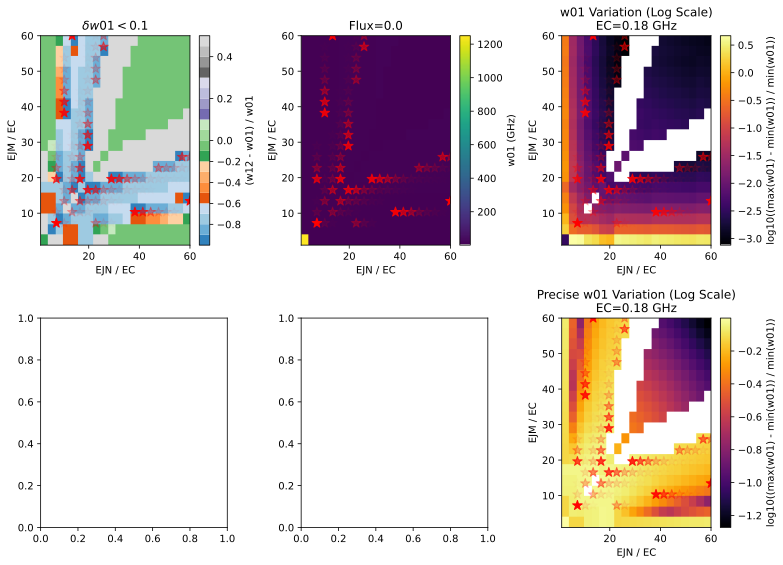

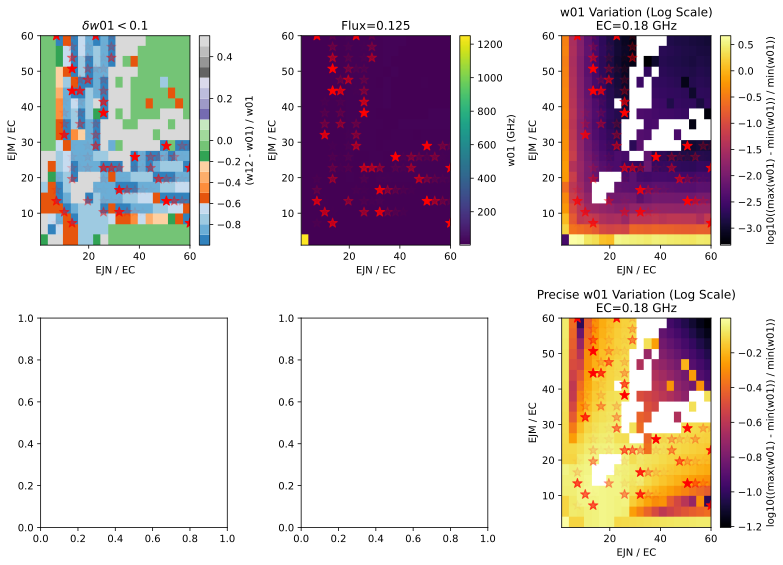

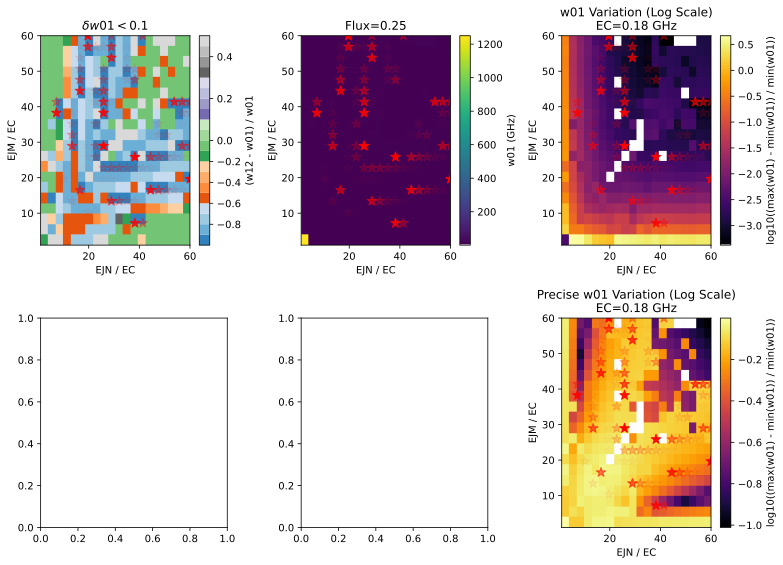

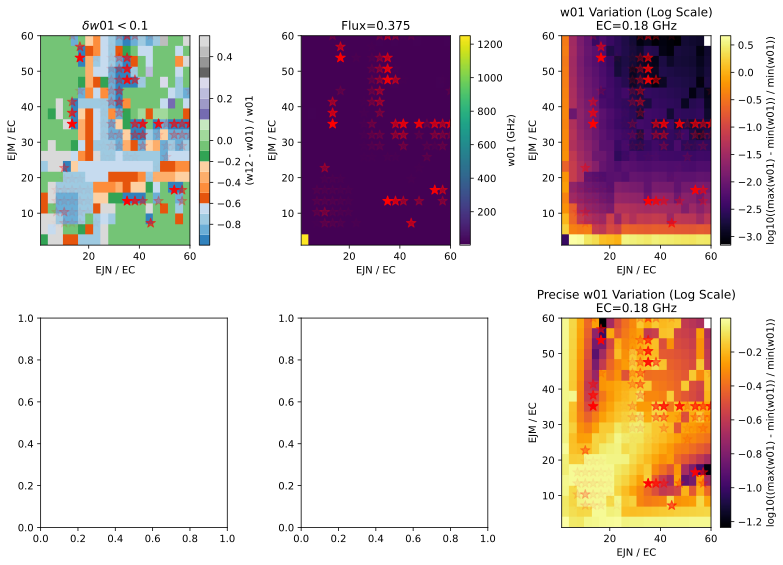

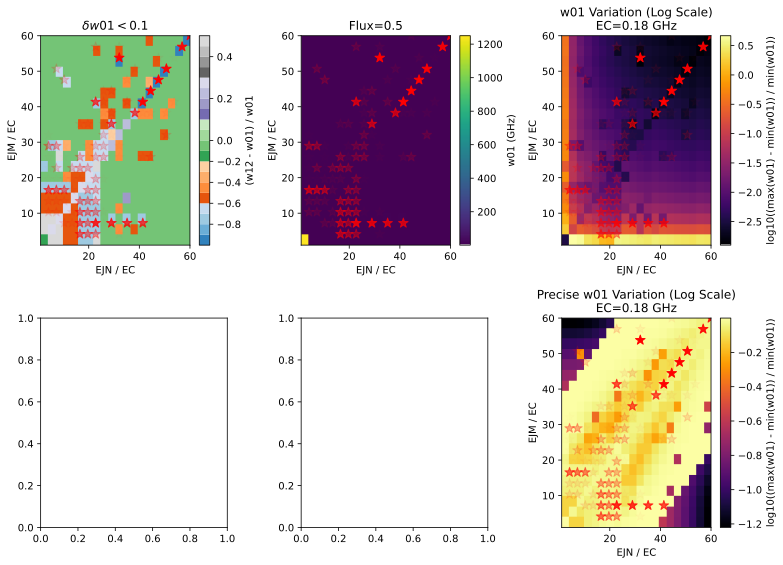

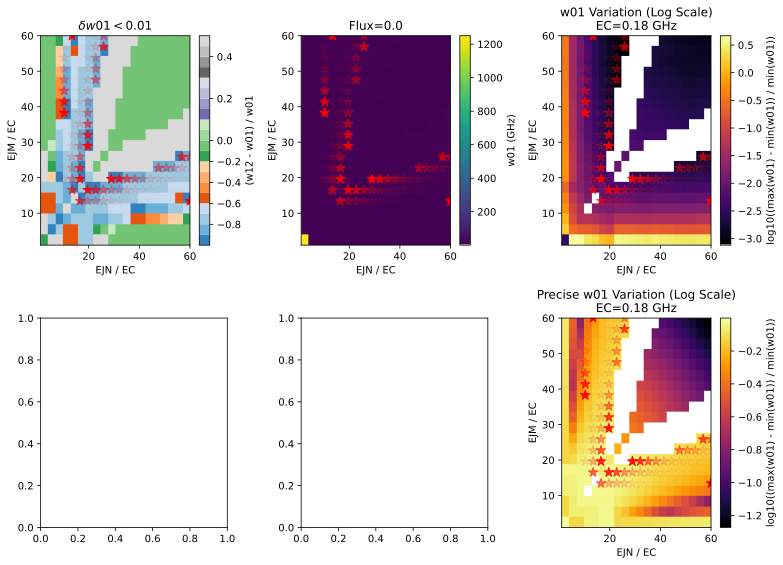

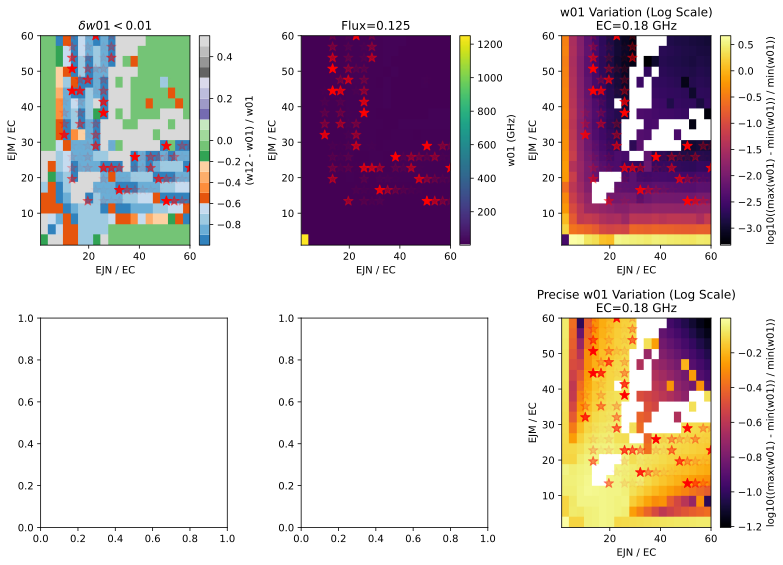

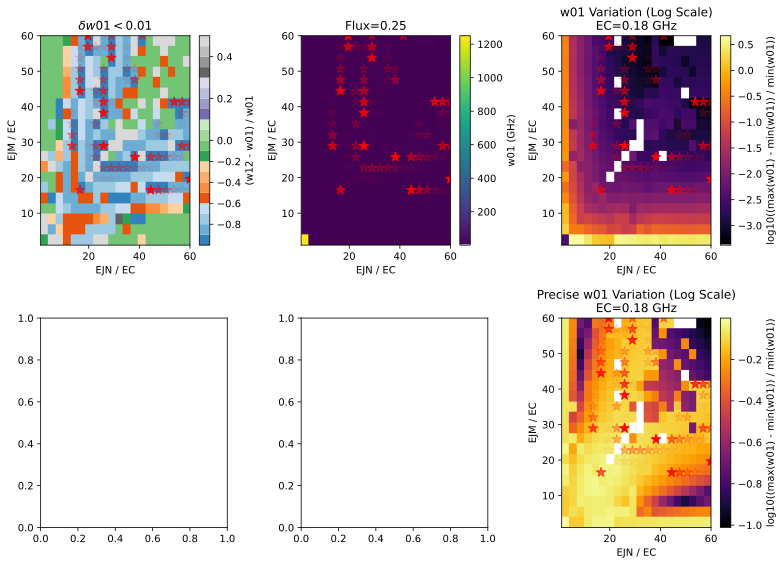

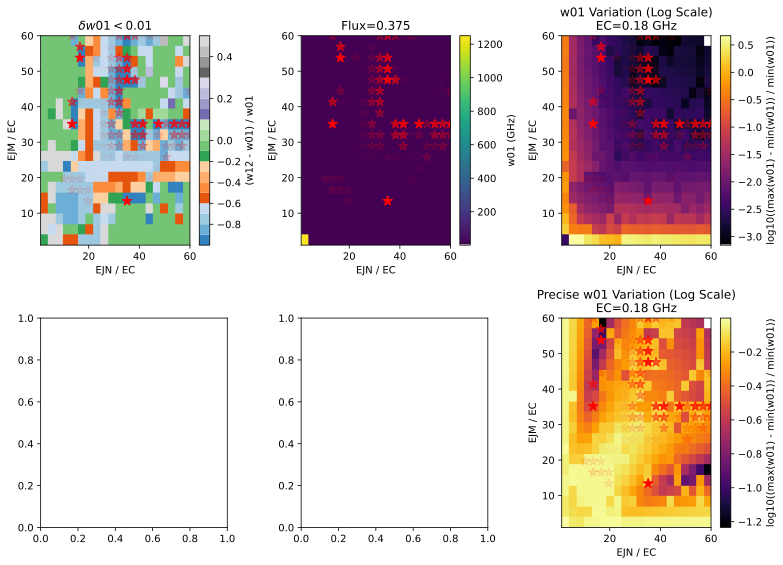

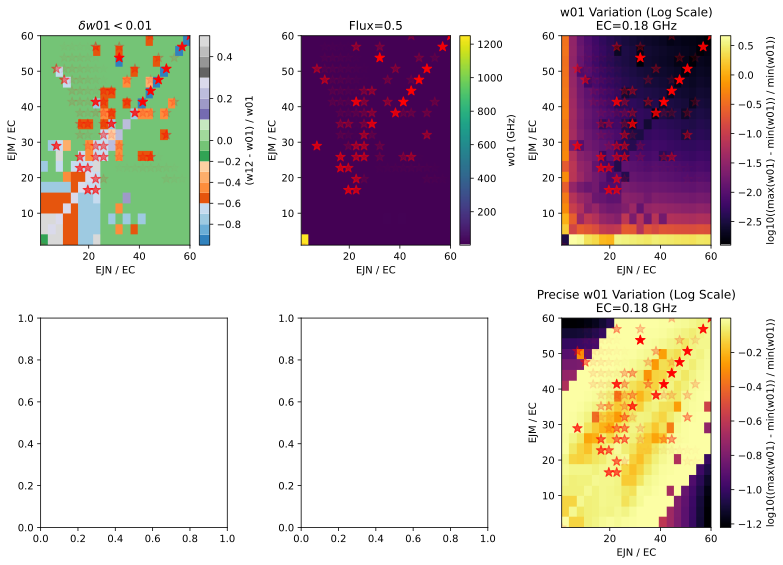

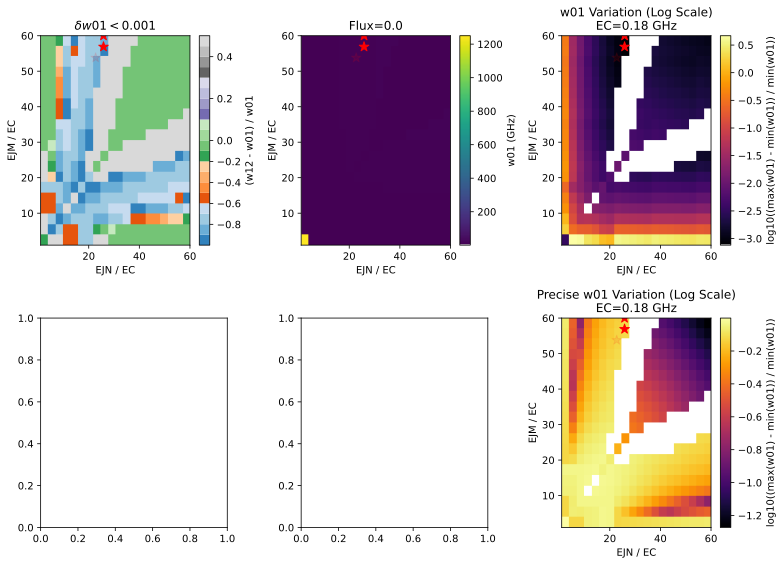

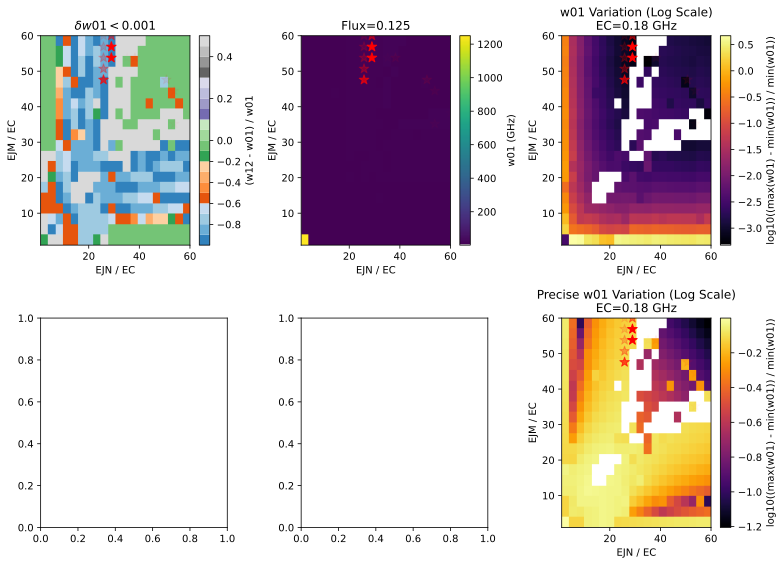

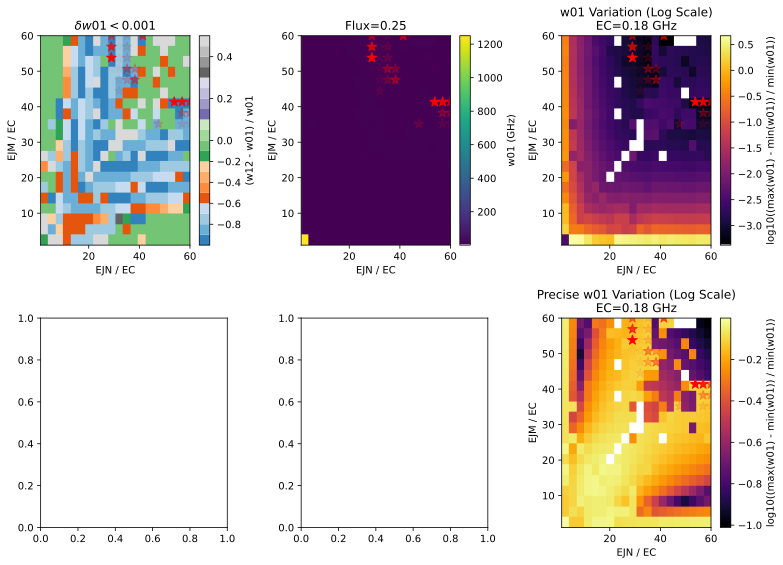

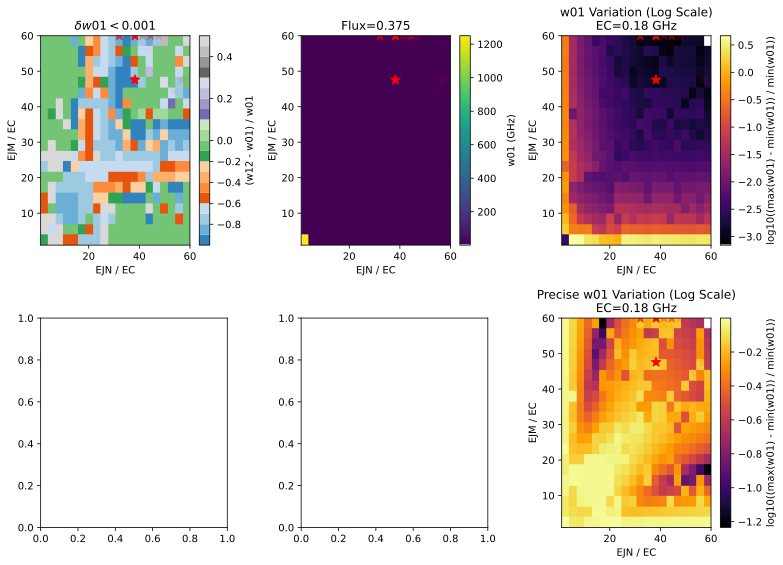

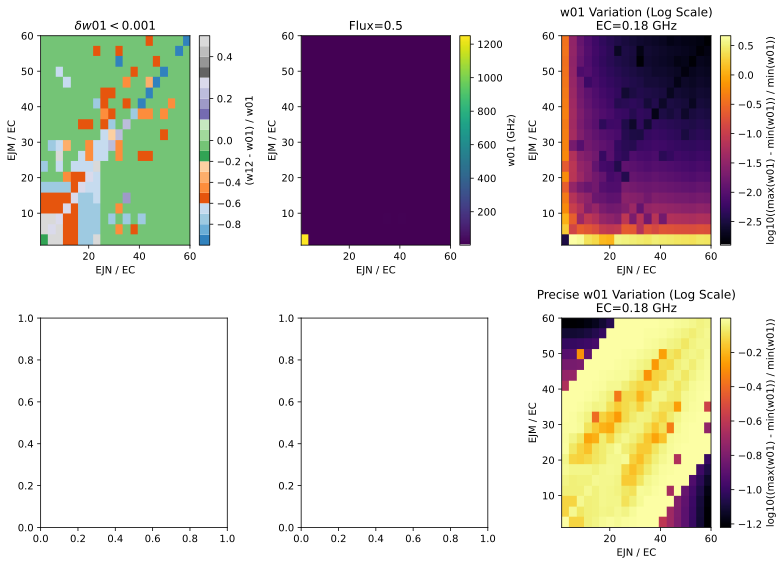

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

w01_variation_levels = [1e-1, 1e-2, 10**(-3)]

for w01_variation_lev in w01_variation_levels:

    for k, flux_value in enumerate(flux_list[:]):

        # k = flux_list.shape[0] - 1

        EJN_grid, EJM_grid = np.meshgrid(EJN_list, EJM_list)

        # Extract arrays for the current flux value
        relative_anharm_list = relative_anharm_list_flux[:, :, k]
        w01_list = w01_list_flux[:, :, k]
        w01_variation_list = w01_variation_list_flux[:, :, k]

        # Replace NaN values in relative_anharm_list
        relative_anharm_list[np.isnan(relative_anharm_list)] = 1

        # Create DataFrame for all data points
        data = {
            'EJN': EJN_grid.flatten(),
            'EJM': EJM_grid.flatten(),
            'RelativeAnharmonicity': relative_anharm_list.flatten(),
            'w01': w01_list.flatten(),
            'w01Variation': w01_variation_list.flatten()
        }
        df = pd.DataFrame(data)

        # Filter rows where w01Variation < 10^(-1)
        filtered_df = df[df['w01Variation'] < w01_variation_lev]

        # Identify the top N_anharm points (lowest anharmonicity values)
        N_anharm = 100
        best_points = filtered_df.nsmallest(N_anharm, 'RelativeAnharmonicity')

        # Adjust alpha values for star-points
        best_anharm_values = best_points['RelativeAnharmonicity'].values
        
        N_anharm = best_anharm_values.shape[0]

        alphas = np.ones(N_anharm)
        for i in range(1, N_anharm):
            if abs(best_anharm_values[i] - best_anharm_values[i - 1]) > 1e-3:
                alphas[i:] = np.logspace(0, -2, N_anharm - i)
                break

        # Plot with imshow and overlay star-points
        fig, axes = plt.subplots(2, 3, figsize=(11, 8))

        # First subplot: Relative Anharmonicity
        norm = colors.TwoSlopeNorm(vmin=df['RelativeAnharmonicity'].min(), vcenter=0, vmax=0.5)
        im1 = axes[0, 0].imshow(relative_anharm_list, extent=[EJN_grid.min() / EC_shunt, EJN_grid.max() / EC_shunt, 
                                                            EJM_grid.min() / EC_shunt, EJM_grid.max() / EC_shunt], 
                                origin='lower', cmap='tab20c', norm=norm, aspect='auto')
        fig.colorbar(im1, ax=axes[0, 0], label='(w12 - w01) / w01')
        axes[0, 0].set_title(r"$\delta w01 < {}$".format(round(w01_variation_lev, 3)))
        axes[0, 0].set_xlabel('EJN / EC')
        axes[0, 0].set_ylabel('EJM / EC')

        if not best_points.empty:
        # Overlay star-points
            axes[0, 0].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)

        # Second subplot: w01
        im2 = axes[0, 1].imshow(w01_list, extent=[EJN_grid.min() / EC_shunt, EJN_grid.max() / EC_shunt, 
                                                EJM_grid.min() / EC_shunt, EJM_grid.max() / EC_shunt], 
                                origin='lower', cmap='viridis', aspect='auto')
        fig.colorbar(im2, ax=axes[0, 1], label='w01 (GHz)')
        axes[0, 1].set_title(f"Flux={flux_value}")
        axes[0, 1].set_xlabel('EJN / EC')
        axes[0, 1].set_ylabel('EJM / EC')

        if not best_points.empty:
        # Overlay star-points
            axes[0, 1].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)

        # Third subplot: Log10 of w01 Variation
        im3 = axes[0, 2].imshow(np.log10(w01_variation_list), extent=[EJN_grid.min() / EC_shunt, EJN_grid.max() / EC_shunt, 
                                                                    EJM_grid.min() / EC_shunt, EJM_grid.max() / EC_shunt], 
                                origin='lower', cmap='inferno', aspect='auto')
        fig.colorbar(im3, ax=axes[0, 2], label='log10((max(w01) - min(w01)) / min(w01))')
        axes[0, 2].set_title(f"w01 Variation (Log Scale)\nEC={round(EC_shunt, 2)} GHz")
        axes[0, 2].set_xlabel('EJN / EC')
        axes[0, 2].set_ylabel('EJM / EC')

        if not best_points.empty:
        # Overlay star-points
            axes[0, 2].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)
        

        im3 = axes[1, 2].imshow(np.log10(w01_variation_list_precise[:, :, k]), extent=[EJN_grid.min() / EC_shunt, EJN_grid.max() / EC_shunt, 
                                                                    EJM_grid.min() / EC_shunt, EJM_grid.max() / EC_shunt], 
                                origin='lower', cmap='inferno', aspect='auto')
        fig.colorbar(im3, ax=axes[1,2], label='log10((max(w01) - min(w01)) / min(w01))')
        axes[1][2].set_title(f"Precise w01 Variation (Log Scale)\nEC={round(EC_shunt, 2)} GHz")
        axes[1][2].set_xlabel('EJN / EC')
        axes[1][2].set_ylabel('EJM / EC')

        if not best_points.empty:
        # Overlay star-points
            axes[1][2].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)
        

        # axes[1][2].plot(x, x,'--', color = 'white', lw=2)

        # Adjust layout and save the figure
        plt.tight_layout()
        plt.savefig(f"./data_figures/N={N}_M={M}_EC={round(EC_shunt, 2)}_flux_{k}_combined_plots.pdf")
        plt.show()


In [50]:
w01_variation_list_precise = np.array(w01_variation_list_precise, dtype=float)
w01_variation_list_precise

array([[[0.74999999, 0.75741761, 0.82112411, 0.9059971 , 1.        ],
        [0.74998754, 0.74998767, 0.74998801, 0.84551659, 1.        ],
        [0.74964514, 0.74964589, 0.74964768, 0.83487409, 1.        ],
        ...,
        [0.83273826, 0.84547303, 0.8817352 , 0.93599827, 1.        ],
        [0.83862219, 0.85090845, 0.88589415, 0.93824846, 1.        ],
        [0.8440572 , 0.8559293 , 0.88973614, 0.94032729, 1.        ]],

       [[0.7499777 , 0.74997784, 0.74997817, 0.84551659, 1.        ],
        [0.74993372, 0.74994322, 0.74996616, 0.7499891 , 1.        ],
        [0.77752991, 0.77542994, 0.76883927, 0.74974983, 1.        ],
        ...,
        [0.31344691, 0.36583798, 0.51487321, 0.73758028, 1.        ],
        [0.33757891, 0.38809615, 0.53184104, 0.74672677, 1.        ],
        [0.35987251, 0.40866732, 0.54753875, 0.75519715, 1.        ]],

       [[0.74935616, 0.7493569 , 0.7493587 , 0.83487409, 1.        ],
        [0.777282  , 0.77517958, 0.76858131, 0.74947031, 1. 

In [24]:
w01_ng_min[:,:,4]

array([[(0.25, 0.25, 0.25), (0.25, 0.25, 0.25), (0.25, 0.25, 0.25),
        (0.25, 0.25, 0.25), (0.25, 0.25, 0.25), (0.25, 0.25, 0.25),
        (0.25, 0.25, 0.25), (0.25, 0.25, 0.25), (0.25, 0.25, 0.25),
        (0.25, 0.25, 0.25), (0, 0.25, 0.5), (0.25, 0.25, 0.25),
        (0, 0.25, 0.5), (0, 0.25, 0.5), (0, 0.25, 0.5), (0, 0.25, 0.5),
        (0, 0.25, 0.5), (0, 0.25, 0.5), (0, 0.25, 0.5), (0, 0.25, 0.5)],
       [(0.25, 0.25, 0.25), (0.25, 0.25, 0.25), (0.25, 0.25, 0.25),
        (0.25, 0.25, 0.25), (0.25, 0.25, 0.25), (0.25, 0.25, 0.25),
        (0.25, 0.25, 0.25), (0.25, 0.25, 0.25), (0, 0.25, 0.5),
        (0, 0.25, 0.5), (0, 0.25, 0.5), (0, 0.25, 0.5), (0, 0.25, 0.5),
        (0, 0.25, 0.5), (0, 0.25, 0.5), (0, 0.25, 0.5), (0, 0.25, 0.5),
        (0, 0.25, 0.5), (0, 0.25, 0.5), (0, 0.25, 0.5)],
       [(0.25, 0.25, 0.25), (0.25, 0.25, 0.25), (0.25, 0.25, 0.25),
        (0.25, 0.25, 0.25), (0.25, 0.25, 0.25), (0.0, 0.5, 0.25),
        (0, 0.25, 0.5), (0.0, 0.5, 0.25), (0, 0.25, 